In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!nvidia-smi

Sat Apr 17 09:55:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir -p ~/.kaggle
!mkdir dataset
#upload kaggle.json manually
!cp ./dataset/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231

!unzip stock-time-series-20050101-to-20171231.zip -d dataset
!ls dataset

mkdir: cannot create directory ‘dataset’: File exists
kaggle.json
  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 99.8MB/s]
Archive:  stock-time-series-20050101-to-20171231.zip
  inflating: dataset/AABA_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/AAPL_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/AMZN_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/AXP_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/BA_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/CAT_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/CSCO_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/CVX_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/DIS_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/GE_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/GOOGL_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/GS_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/HD_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/IBM_2006-01-01_to_2018-01-01.csv  
  inflating: dataset/I

In [ ]:
train_data = pd.read_csv('dataset/AAPL_2006-01-01_to_2018-01-01.csv', encoding='L1')
train_data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [ ]:
train_data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [ ]:
dates = train_data['Date'].values
tempOpen  = train_data['Open'].values
tempHigh = train_data['High'].values
tempLow = train_data['Low'].values
tempClose = train_data['Close'].values

minMae = ((tempOpen.max() - tempOpen.min()) * 10/100) + tempOpen.min()
 
import plotly.graph_objects as go
!pip install chart_studio
from plotly.offline import init_notebook_mode, iplot
 
data_plot = pd.read_csv('dataset/AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
data_plot.head()
trace = go.Ohlc(x=data_plot['2008'].index,
                open=data_plot['2008'].Open,
                high=data_plot['2008'].High,
                low=data_plot['2008'].Low,
                close=data_plot['2008'].Close)
data = [trace]
print('Min MAE : '+str(minMae))
print('Min MAE : '+str(minMae))
print('Min MAE : '+str(minMae))
iplot(data, filename='simple_ohlc')

     |████████████████████████████████| 71kB 7.8MB/s 
Min MAE : 24.162000000000003
Min MAE : 24.162000000000003
Min MAE : 24.162000000000003


In [ ]:
import cv2

print('Sebelum normalization')
print(tempOpen[:10])
out = np.zeros(tempOpen.shape, np.double)
tempOpen = cv2.normalize(tempOpen, out, 1.0, 0.0, cv2.NORM_MINMAX)
print('Setelah normalization')
print(tempOpen[:10])

size_arr = tempOpen.shape[0]
delapanPuluhPersen = int(80 * size_arr / 100)

val_open = tempOpen[delapanPuluhPersen:]
train_open = tempOpen[:delapanPuluhPersen]


#val_close = tempClose[delapanPuluhPersen:]
#train_close = tempClose[:delapanPuluhPersen]

Sebelum normalization
[10.34 10.73 10.69 10.75 10.96 10.89 11.98 12.14 12.14 12.24]
Setelah normalization
[0.01758884 0.01991414 0.01967565 0.02003339 0.02128548 0.02086811
 0.02736704 0.02832101 0.02832101 0.02891724]


In [ ]:
def windowed_dataset(trainOpen, valOpen, window_size, batch_size, shuffle_buffer):
    seriesOpen = trainOpen
    seriesOpen = tf.expand_dims(seriesOpen, axis=-1)
    dsOpen = tf.data.Dataset.from_tensor_slices(seriesOpen)
    dsOpen = dsOpen.window(window_size + 1, shift=1, drop_remainder=True)
    dsOpen = dsOpen.flat_map(lambda w: w.batch(window_size + 1))
    dsOpen = dsOpen.shuffle(shuffle_buffer)
    dsOpen = dsOpen.map(lambda w: (w[:-1], w[-1:]))
    dsOpen = dsOpen.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    seriesOpen2 = tf.expand_dims(valOpen, axis=-1)
    valOpen = tf.data.Dataset.from_tensor_slices(seriesOpen2)
    valOpen = valOpen.window(window_size + 1, shift=1, drop_remainder=True)
    valOpen = valOpen.flat_map(lambda w: w.batch(window_size + 1))
    valOpen = valOpen.shuffle(shuffle_buffer)
    valOpen = valOpen.map(lambda w: (w[:-1], w[-1:]))
    valOpen = valOpen.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    #data dibagi menjadi banyak 100 jendela, 
    #1 jendela berisi 60 data, urutan jendela dishuffle, y adalah nilai terakhir dari tiap jendela, makanya window_size +1, +1 nya untuk y
    return [dsOpen, valOpen]

dataOpen, valOpen = windowed_dataset(train_open, val_open, window_size=60, batch_size=100, shuffle_buffer=1000)

In [ ]:
print("Size train Open : "+str(len(train_open)))
print("Size validation Open : "+str(len(val_open)))

Size train Open : 2415
Size validation Open : 604


In [ ]:
from tensorflow.keras import Model, Sequential

model_conv = Sequential()
model_conv.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.4, recurrent_dropout = 0.4, return_sequences=True)))
model_conv.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.4, recurrent_dropout = 0.4, return_sequences=True)))
model_conv.add(tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'))
model_conv.add(tf.keras.layers.BatchNormalization(axis=-1))
model_conv.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_conv.add(tf.keras.layers.Dense(64, activation='relu'))
model_conv.add(tf.keras.layers.Dropout(0.4))
model_conv.add(tf.keras.layers.Dense(32, activation='relu'))
model_conv.add(tf.keras.layers.Dropout(0.4))
model_conv.add(tf.keras.layers.Dense(16, activation='relu'))
model_conv.add(tf.keras.layers.Dropout(0.4))
model_conv.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model_conv.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
print('Min MAE : '+str(minMae))

Min MAE : 24.162000000000003


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/My Drive/TimeSeries4Bidirec2Conv04Dropoutfinal.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

history = model_conv.fit(dataOpen,epochs=200, validation_data=valOpen, callbacks = checkpoint)


Epoch 1/200
24/24 [==============================] - 28s 780ms/step - loss: 0.0796 - mae: 0.3087 - val_loss: 0.2595 - val_mae: 0.7048

Epoch 00001: val_mae improved from inf to 0.70480, saving model to /content/gdrive/My Drive/TimeSeries4Bidirec2Conv04Dropoutfinal.h5
Epoch 2/200
24/24 [==============================] - 18s 738ms/step - loss: 0.0345 - mae: 0.1966 - val_loss: 0.2531 - val_mae: 0.6957

Epoch 00002: val_mae improved from 0.70480 to 0.69572, saving model to /content/gdrive/My Drive/TimeSeries4Bidirec2Conv04Dropoutfinal.h5
Epoch 3/200
24/24 [==============================] - 18s 740ms/step - loss: 0.0287 - mae: 0.1713 - val_loss: 0.2453 - val_mae: 0.6844

Epoch 00003: val_mae improved from 0.69572 to 0.68437, saving model to /content/gdrive/My Drive/TimeSeries4Bidirec2Conv04Dropoutfinal.h5
Epoch 4/200
24/24 [==============================] - 18s 730ms/step - loss: 0.0237 - mae: 0.1522 - val_loss: 0.2324 - val_mae: 0.6655

Epoch 00004: val_mae improved from 0.68437 to 0.66545

# **Best val_mae : 0.09956**

In [ ]:
print(model_conv.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, None, 256)         133120    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 128)         164352    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 128)         512       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
dense_10 (Dense)             (None, None, 64)          8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)         

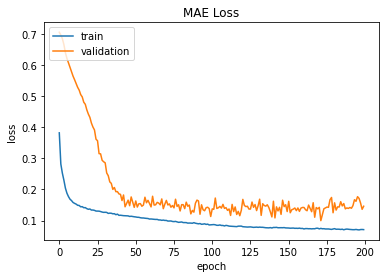

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras import Model, Sequential

model_conv = Sequential()
model_conv.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.5, recurrent_dropout = 0.5, return_sequences=True)))
model_conv.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.5, recurrent_dropout = 0.5, return_sequences=True)))
model_conv.add(tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'))
model_conv.add(tf.keras.layers.BatchNormalization(axis=-1))
model_conv.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_conv.add(tf.keras.layers.Dense(64, activation='relu'))
model_conv.add(tf.keras.layers.Dropout(0.5))
model_conv.add(tf.keras.layers.Dense(32, activation='relu'))
model_conv.add(tf.keras.layers.Dropout(0.5))
model_conv.add(tf.keras.layers.Dense(16, activation='relu'))
model_conv.add(tf.keras.layers.Dropout(0.5))
model_conv.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model_conv.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])